## Introduction 

In this project, the goal is to create an algorithm to identify metastatic cancer in small image patches taken from pathology scans. The scan size is 96 x 96 x 3 pixels, and the dimension of the training dataset is 220,025 samples, with 130,908 negatives and 89,117 positives. Here, "negative" implies no tumor present, whereas "positive" implies tumor present.

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import random
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential
from keras import regularizers, optimizers
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import RMSprop

In [2]:
train_folder = "train"
test_folder = "test"
labels_file = "train_labels.csv"

In [3]:
labels_df = pd.read_csv(labels_file)
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


## EDA

It is import for a binary classification problem to have balanced dataset, we will visualize the class distribution for this dataset.

Negative: 130908
Positive: 89117


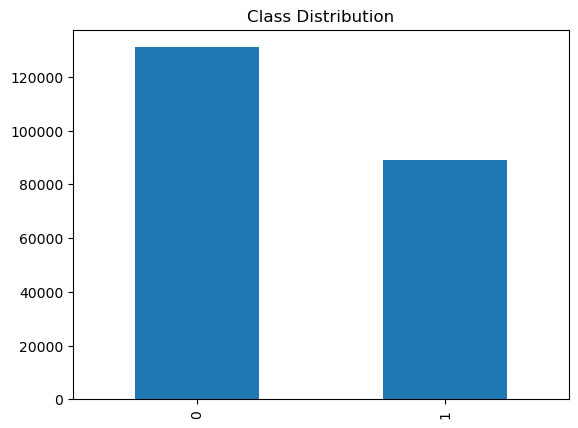

In [4]:
labels_df['label'].value_counts().plot(kind='bar')
plt.title("Class Distribution")
print("Negative:", sum(labels_df["label"] == 0))
print("Positive:", sum(labels_df["label"] == 1))

The dataset is not balance, this might create some problems including biased model performance. We will try to balance this dataset so they have the equal amount of positive and negative data.

,id,label
0,b29a76b9cf6c4c4d804886097a9ef7b865e0f30c,1
1,a97a1a95e7dc59a523b3eb2e2b68ac26460a04f9,0
2,0aba5241eab20a41f6ebd867cab1e5a4fd7e3344,1
3,2bb524f7cdf9a0466fa9322be0739acaa95478c8,1
4,640e56516dcacdab18697e9412d254b342794fe8,1


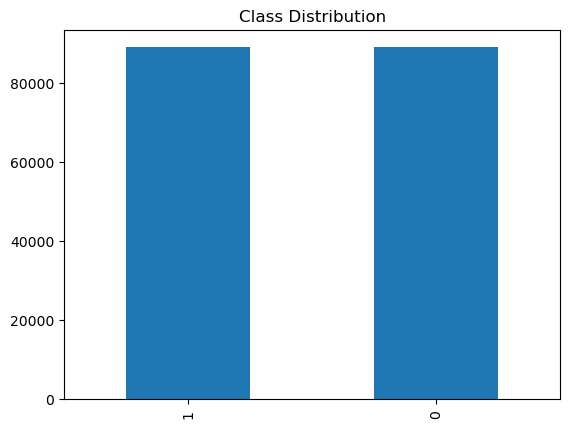

In [166]:
pos_labels = labels_df[labels_df["label"] == 1]
neg_labels = labels_df[labels_df["label"] == 0]
neg_labels = neg_labels.sample(n = len(pos_labels))

labels_df = shuffle(pd.concat([pos_labels, neg_labels]))
labels_df = labels_df.reset_index(drop=True)
labels_df['label'].value_counts().plot(kind='bar')
plt.title("Class Distribution")

labels_df.head()

With the dataset being balanced, we will proceed to visualize the pathology scans.

In [175]:
num_samples = len(labels_df)
random_ind = random.sample(range(num_samples), 8)

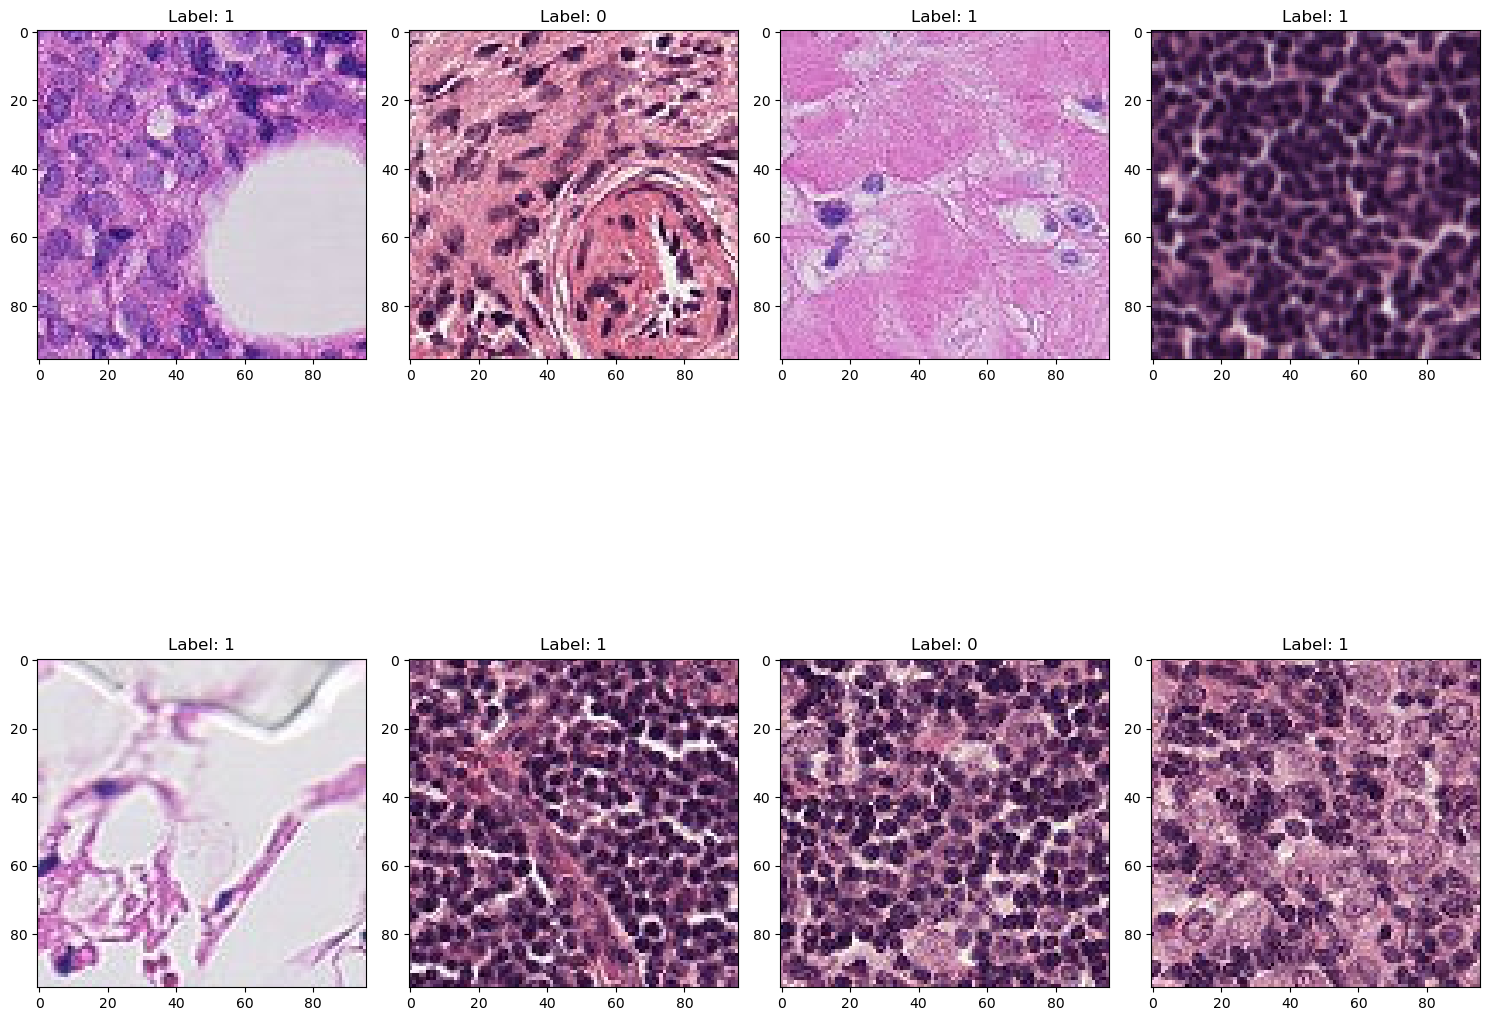

In [181]:
fig, ax = plt.subplots(2, 4,figsize=(15,15))

for i in range(0, len(random_ind)):
    ax = plt.subplot(2, 4, i+1)
    img = mpimg.imread(f'train/{labels_df.iloc[random_ind[i],0]}.tif')
    ax.imshow(img)
    ax.set_title(f"Label: {labels_df['label'][i]}")
    
plt.tight_layout()

## Model Architecture

I will be using the VGGNet model to train my dataset. VGGNet is primarily composed of 3x3 convolutional filters with a stride of 1 and a max-pooling layer with a 2x2 window and a stride of 2. The main reason I chose this model is the uniform filter size of 3 x 3 throughout the network and its ability to capture complex and hierarchical patterns in images.

First, I will split the training and validation dataset into 80/20.

In [8]:
train_df, valid_df = train_test_split(labels_df, test_size=0.2, random_state=151)

In [9]:
def append_tif(fn):
    return fn+".tif"
train_df["id"]=train_df["id"].apply(append_tif)
valid_df["id"]=valid_df["id"].apply(append_tif)

train_df['label'] = train_df['label'].astype(str)
valid_df['label'] = valid_df['label'].astype(str)

In [10]:
datagen=ImageDataGenerator(rescale=1/255)

train_generator=datagen.flow_from_dataframe(dataframe=train_df, directory="./train/",x_col="id",y_col="label",
                                            batch_size=32,seed=151,shuffle=True,class_mode="binary",
                                            target_size=(96,96))

valid_generator=datagen.flow_from_dataframe(dataframe=valid_df, directory="./train/",x_col="id",y_col="label",
                                            batch_size=32,seed=151,shuffle=True,class_mode="binary",
                                            target_size=(96,96))

Found 142587 validated image filenames belonging to 2 classes.
Found 35647 validated image filenames belonging to 2 classes.


I will train the model using sigmoid activation and RMSprop optimizer with learning rate of 0.001.

In [53]:
# Reference: https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c
model1 = Sequential()
model1.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model1.add(Activation('relu'))
model1.add(Conv2D(32, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())

model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(Conv2D(64, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())

model1.add(Conv2D(128, (3, 3)))
model1.add(Activation('relu'))
model1.add(Conv2D(128, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())

model1.add(Conv2D(256, (3, 3)))
model1.add(Activation('relu'))
model1.add(Conv2D(256, (3, 3)))
model1.add(Activation('relu'))
model1.add(MaxPooling2D(pool_size=(2, 2)))
model1.add(BatchNormalization())
          
model1.add(Flatten())
model1.add(Dropout(0.25))
model1.add(Dense(256))
model1.add(Activation('relu')) 

model1.add(Dense(1, activation='sigmoid'))
model1.compile(loss='binary_crossentropy', optimizer=RMSprop(learning_rate=0.001), metrics=['accuracy'])

In [54]:
step_train=train_generator.n//train_generator.batch_size
step_valid=valid_generator.n//valid_generator.batch_size
history1 = model1.fit_generator(generator=train_generator,
                    steps_per_epoch=step_train,
                    validation_data=valid_generator,
                    validation_steps=step_valid,
                    epochs=10)

Epoch 1/10


/var/folders/vs/hj3lhms946ndvd2b0jc239r80000gn/T/ipykernel_86498/1515781629.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model1.fit_generator(generator=train_generator,


4455/4455 [==============================] - 1161s 260ms/step - loss: 0.3992 - accuracy: 0.8296 - val_loss: 0.5419 - val_accuracy: 0.7999
Epoch 2/10
4455/4455 [==============================] - 1160s 260ms/step - loss: 0.2987 - accuracy: 0.8794 - val_loss: 1.5077 - val_accuracy: 0.6683
Epoch 3/10
4455/4455 [==============================] - 1158s 260ms/step - loss: 0.2560 - accuracy: 0.8996 - val_loss: 0.8639 - val_accuracy: 0.7528
Epoch 4/10
4455/4455 [==============================] - 1150s 258ms/step - loss: 0.2300 - accuracy: 0.9116 - val_loss: 0.3897 - val_accuracy: 0.8465
Epoch 5/10
4455/4455 [==============================] - 1262s 283ms/step - loss: 0.2104 - accuracy: 0.9196 - val_loss: 0.6711 - val_accuracy: 0.8155
Epoch 6/10
4455/4455 [==============================] - 1269s 285ms/step - loss: 0.1975 - accuracy: 0.9256 - val_loss: 0.4038 - val_accuracy: 0.8612
Epoch 7/10
4455/4455 [==============================] - 1187s 266ms/step - loss: 0.1861 - accuracy: 0.9307 - val_loss

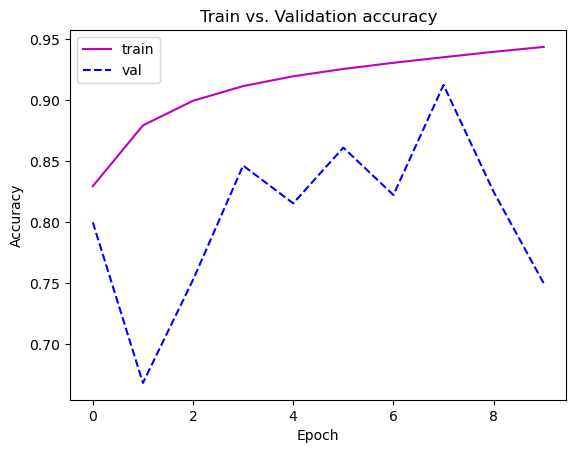

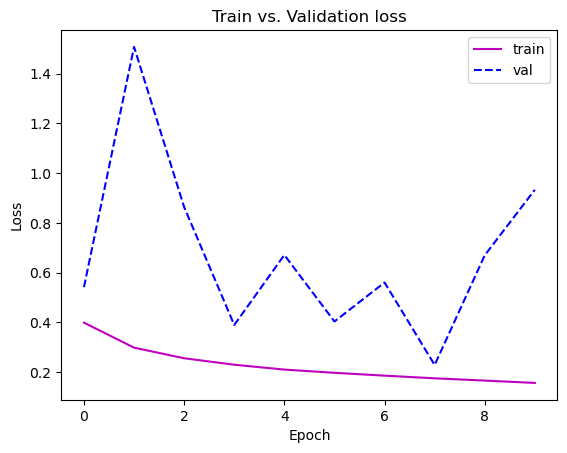

In [185]:
def plot(history):
    plt.plot(history.history['accuracy'], 'm', label="train")
    plt.plot(history.history['val_accuracy'], 'b--', label="val")
    plt.title('Train vs. Validation accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    
    plt.plot(history.history['loss'],'m',label="train")
    plt.plot(history.history['val_loss'], 'b--',label="val" )
    plt.title('Train vs. Validation loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()
    

plot(history1)

In [16]:
model2 = Sequential()
model2.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model2.add(Activation('relu'))
model2.add(Conv2D(32, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(64, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(128, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())

model2.add(Conv2D(256, (3, 3)))
model2.add(Activation('relu'))
model2.add(Conv2D(256, (3, 3)))
model2.add(Activation('relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(BatchNormalization())
          
model2.add(Flatten())
model2.add(Dropout(0.25))
model2.add(Dense(256))
model2.add(Activation('relu')) 

model2.add(Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=['accuracy'])

In [17]:
step_train=train_generator.n//train_generator.batch_size
step_valid=valid_generator.n//valid_generator.batch_size
history2 = model2.fit_generator(generator=train_generator,
                    steps_per_epoch=step_train,
                    validation_data=valid_generator,
                    validation_steps=step_valid,
                    epochs=10)

Epoch 1/10


/var/folders/vs/hj3lhms946ndvd2b0jc239r80000gn/T/ipykernel_86498/136784717.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model2.fit_generator(generator=train_generator,


4455/4455 [==============================] - 1163s 261ms/step - loss: 0.3915 - accuracy: 0.8310 - val_loss: 0.3694 - val_accuracy: 0.8326
Epoch 2/10
4455/4455 [==============================] - 1183s 266ms/step - loss: 0.2845 - accuracy: 0.8825 - val_loss: 0.4407 - val_accuracy: 0.8037
Epoch 3/10
4455/4455 [==============================] - 1162s 261ms/step - loss: 0.2405 - accuracy: 0.9048 - val_loss: 0.3071 - val_accuracy: 0.8726
Epoch 4/10
4455/4455 [==============================] - 1176s 264ms/step - loss: 0.2132 - accuracy: 0.9163 - val_loss: 0.3944 - val_accuracy: 0.8581
Epoch 5/10
4455/4455 [==============================] - 1160s 260ms/step - loss: 0.1901 - accuracy: 0.9265 - val_loss: 0.2122 - val_accuracy: 0.9173
Epoch 6/10
4455/4455 [==============================] - 1162s 261ms/step - loss: 0.1741 - accuracy: 0.9336 - val_loss: 0.2457 - val_accuracy: 0.9127
Epoch 7/10
4455/4455 [==============================] - 1165s 261ms/step - loss: 0.1617 - accuracy: 0.9391 - val_loss

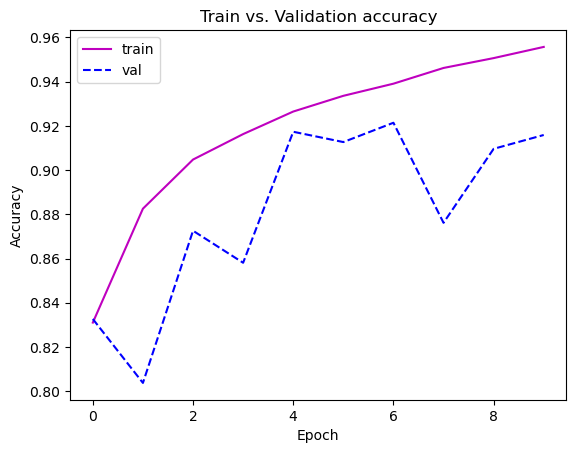

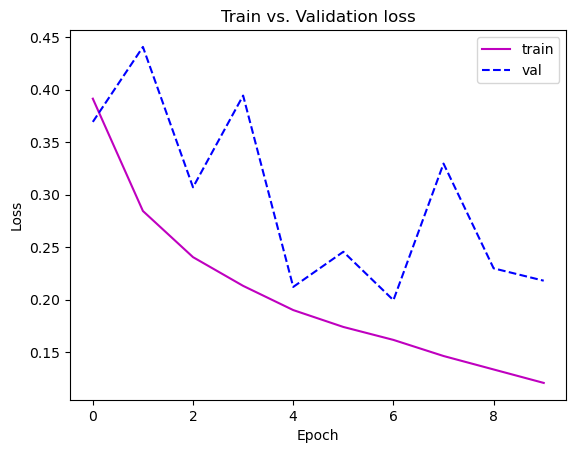

In [186]:
plot(history2)

# Result and Analysis

I will hypertune the activation function. Eventhough softmax function is used for multi-class classification, I would like to try applying softmax for this project treating one class as the positive class and the other class as the negative class.

In [19]:
model3 = Sequential()
model3.add(Conv2D(32, (3, 3), padding='same',input_shape=(96,96,3)))
model3.add(Activation('relu'))
model3.add(Conv2D(32, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())

model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(64, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())

model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(128, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())

model3.add(Conv2D(256, (3, 3)))
model3.add(Activation('relu'))
model3.add(Conv2D(256, (3, 3)))
model3.add(Activation('relu'))
model3.add(MaxPooling2D(pool_size=(2, 2)))
model3.add(BatchNormalization())
          
model3.add(Flatten())
model3.add(Dropout(0.25))
model3.add(Dense(256))
model3.add(Activation('relu')) 

model3.add(Dense(1, activation='softmax'))
model3.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=['accuracy'])

In [25]:
step_train=train_generator.n//train_generator.batch_size
step_valid=valid_generator.n//valid_generator.batch_size
history3 = model3.fit_generator(generator=train_generator,
                    steps_per_epoch=step_train,
                    validation_data=valid_generator,
                    validation_steps=step_valid,
                    epochs=10)

Epoch 1/10


/var/folders/vs/hj3lhms946ndvd2b0jc239r80000gn/T/ipykernel_86498/3856009031.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = model3.fit_generator(generator=train_generator,


4455/4455 [==============================] - 1150s 258ms/step - loss: 0.3226 - accuracy: 0.4996 - val_loss: 1.8666 - val_accuracy: 0.5015
Epoch 2/10
4455/4455 [==============================] - 1150s 258ms/step - loss: 0.2649 - accuracy: 0.4996 - val_loss: 0.2326 - val_accuracy: 0.5016
Epoch 3/10
4455/4455 [==============================] - 1145s 257ms/step - loss: 0.2310 - accuracy: 0.4996 - val_loss: 0.2630 - val_accuracy: 0.5017
Epoch 4/10
4455/4455 [==============================] - 1143s 256ms/step - loss: 0.2089 - accuracy: 0.4996 - val_loss: 0.3533 - val_accuracy: 0.5017
Epoch 5/10
4455/4455 [==============================] - 1147s 257ms/step - loss: 0.1921 - accuracy: 0.4996 - val_loss: 0.2594 - val_accuracy: 0.5015
Epoch 6/10
4455/4455 [==============================] - 1156s 260ms/step - loss: 0.1778 - accuracy: 0.4996 - val_loss: 0.7693 - val_accuracy: 0.5016
Epoch 7/10
4455/4455 [==============================] - 1169s 262ms/step - loss: 0.1632 - accuracy: 0.4996 - val_loss

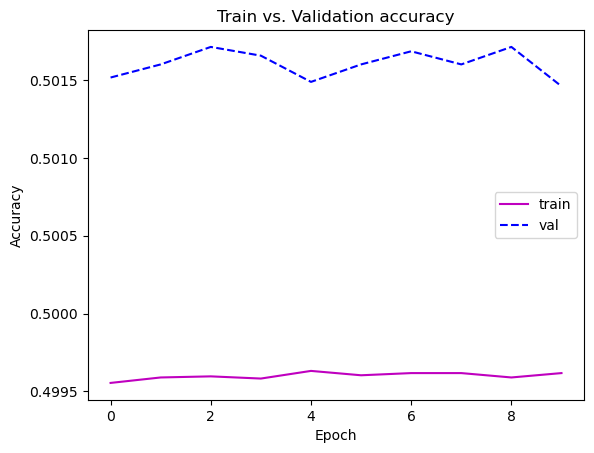

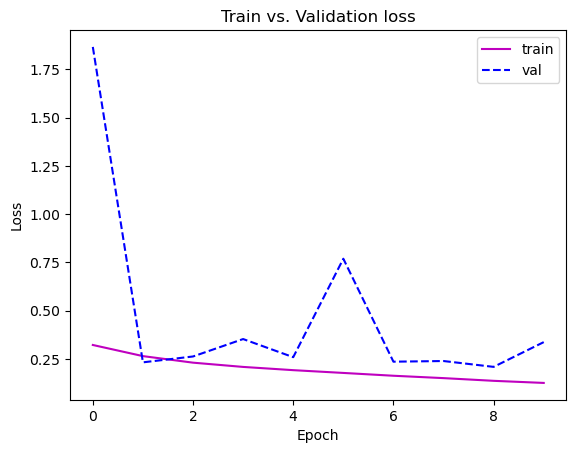

In [187]:
plot(history3)

In [139]:
test_df = pd.DataFrame({'id': os.listdir(test_folder)})
test_df.head()

,id
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif
2,19709bec800f372d0b1d085da6933dd3ef108846.tif
3,7a34fc34523063f13f0617f7518a0330f6187bd3.tif
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif


In [121]:
test_datagen=ImageDataGenerator(rescale=1/255)

test_generator=test_datagen.flow_from_dataframe(dataframe=test_df,directory="./test/",
                x_col="id",batch_size=32,seed=151,shuffle=False,
                class_mode=None,target_size=(96,96))

Found 57458 validated image filenames.


In [128]:
step_test=test_generator.n//test_generator.batch_size
pred = model2.predict_generator(generator=test_generator,
                 steps=step_test+1, verbose=1)

   1/1796 [..............................] - ETA: 3:31

/var/folders/vs/hj3lhms946ndvd2b0jc239r80000gn/T/ipykernel_86498/2329949388.py:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred = model2.predict_generator(generator=test_generator,


1796/1796 [==============================] - 121s 67ms/step


In [130]:
#check the shape to see if it is correct 
pred.shape #correct size

(57458, 1)

In [140]:
test_df['label'] = pred
test_df.head()

,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d.tif,0.274240
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581.tif,0.003302
2,19709bec800f372d0b1d085da6933dd3ef108846.tif,0.941095
3,7a34fc34523063f13f0617f7518a0330f6187bd3.tif,0.420451
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed.tif,0.007092


In [156]:
# We want the label to be either 1 or 0
test_df['label'] = np.where(test_df['label'] >= 0.5, 1, 0)

In [165]:
# remove .tif for submission
test_df['id'] = test_df['id'].str.replace('.tif', '')
test_df

/var/folders/vs/hj3lhms946ndvd2b0jc239r80000gn/T/ipykernel_86498/280548837.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df['id'] = test_df['id'].str.replace('.tif', '')


,id,label
0,fd0a060ef9c30c9a83f6b4bfb568db74b099154d,0
1,1f9ee06f06d329eb7902a2e03ab3835dd0484581,0
2,19709bec800f372d0b1d085da6933dd3ef108846,1
3,7a34fc34523063f13f0617f7518a0330f6187bd3,0
4,93be720ca2b95fe2126cf2e1ed752bd759e9b0ed,0
...,...,...
57453,2581931c6ef068f105a872f2c5500275fc678242,0
57454,11b250a664d09ab59fd2afbdb2f8d786763b185d,1
57455,18a6030935ec1ef1ce486ec51bc95abb4008fbf1,0
57456,f541404e501e23a0188c852eb37eac94053cfdc0,0


In [164]:
test_df.to_csv('submission.csv', index=False)

# Conclusion

Model 2 achieved the best results among the three models, followed by model 1 and model 3. It exhibited high accuracy for both training and validation, with a more stable and higher validation accuracy compared to model 1. By using model 2, this algorithm was able to achieve an accuracy score of 0.8814 on the test dataset. Due to the computational cost of the VGGNet architecture, which took approximately 10 hours to train over around 30 epochs, future studies can explore less time-consuming models to further experiment and hypertune additional parameters.

reference:
https://vijayabhaskar96.medium.com/tutorial-on-keras-flow-from-dataframe-1fd4493d237c